# Evaluating Denoising Efficiency

## Introduction 

Simulated using MIRT as described in [Nelson et al., 2023](https://onlinelibrary.wiley.com/doi/abs/10.1002/mp.16901) where the acquisition parameters are meant to simulate the Siemens Somatom Definition AS+, which is one of the scanners used in developing the [Low Dose CT Grand Challenge Dataset](https://aapm.onlinelibrary.wiley.com/doi/full/10.1002/mp.12345). However I still need to be careful that this is an approximation and there still may be mismatch between the real and simulated scans, though [Zeng et al., 2022](http://onlinelibrary.wiley.com/doi/abs/10.1002/mp.15430) validated the simulations with physical scans based on MTF and NPS performance measures.

**Question**: Data augmentation is a common approach for dealing with limited datasets. Can data augmentation techniques be used to make up for limited pediatric data?

**Hypothesis**: Noise textures from pediatric-sized phantom scans can be used as an effective data augmentation to improve denoising model generalizability to pediatric patients.

*Purpose* to test our hypothesis that training with noise augmentation can improve performance in pediatric patients. This notebook presents the results in terms of denoising efficiency, which we define in two ways depending on the data available.


If even that doesn't exist you can select a region that is assumed to be uniform and compare measured standard deviation $\sigma$ in the region:

$$
\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i' - \mu)^2},\text{ where } \mu = \frac{1}{N} \sum_{i=1}^N x'_i
$$

here we assume a uniform region such that that $\bar{x}$ is assumed to be the true value for an unbiased measurement in a uniform region

We can thus define noise reduction both in terms of noise std [HU] and RMSE as:

$$
\text{Noise Reduction} = 100\% \times \frac{(\text{FBP} - \text{denoised})}{\text{FBP}}
$$

Defining noise reduction relative to the original FBP noise level

## Noise Reduction in Uniform Phantoms

In [1]:
!ls /gpfs_projects/brandon.nelson/RSTs/pediatricIQphantoms/

CTP404	metadata.csv  MITA-LCD	uniform


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pydicom

base_dir = Path('/gpfs_projects/brandon.nelson/RSTs/pediatricIQphantoms/')
meta = pd.read_csv(base_dir / 'metadata.csv')
meta = meta[meta.phantom == 'uniform']
meta.file = meta.file.apply(lambda o: base_dir / o)
meta.head()

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],file,patientid,studyid,series,repeat
3544,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,0
3545,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,1
3546,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,2
3547,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,3
3548,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,4


In [3]:
sorted(meta['FOV [cm]'].unique())

[12.0, 14.0, 17.0, 20.0, 24.0, 32.0, 34.0, 39.0]

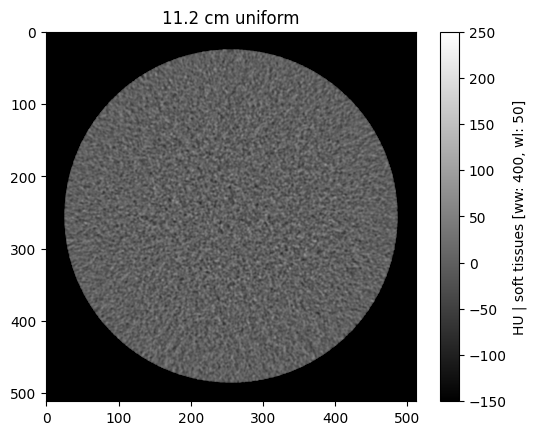

In [4]:
from utils import browse_studies, study_viewer
browse_studies(meta, phantom='uniform', fov=12, dose=100, recon='fbp')

In [5]:
study_viewer(meta)

interactive(children=(Dropdown(description='phantom', options=('uniform',), value='uniform'), Dropdown(descrip…

## Apply a denoiser

In [6]:
import sys
import os
import torch
from denoising.networks import RED_CNN

def read_dicom(dcm_file):
    dcm = pydicom.read_file(dcm_file)
    return dcm.pixel_array + float(dcm.RescaleIntercept)

def load_model(save_path, iter_=13000, multi_gpu=False):
    REDCNN = RED_CNN()
    f = os.path.join(save_path, 'REDCNN_{}iter.ckpt'.format(iter_))
    REDCNN.load_state_dict(torch.load(f))
    return REDCNN

denoising_model  = load_model('denoising/models/redcnn')

In [7]:
meta.studyid.unique()

array([64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
       81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [8]:
vol = np.array([read_dicom(o) for o in meta[meta['studyid'] == 64].file])
vol.shape

(200, 512, 512)

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

denoising_model.to(device)
batch_size = 32 #play around with an inference batch size that fits on your gpu

denoised = denoising_model.predict(vol[:, None], device=device, batch_size=batch_size)

100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.31it/s]


In [10]:
meta[(meta['Dose [%]'] == 25)]

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],file,patientid,studyid,series,repeat
3544,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,0
3545,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,1
3546,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,2
3547,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,3
3548,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6553,35.0 cm uniform,35.0,39.000000,adult,uniform,Siemens Somatom Definition,25.0,fbp,D45,39.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,23.0,92,simulation,195
6554,35.0 cm uniform,35.0,39.000000,adult,uniform,Siemens Somatom Definition,25.0,fbp,D45,39.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,23.0,92,simulation,196
6555,35.0 cm uniform,35.0,39.000000,adult,uniform,Siemens Somatom Definition,25.0,fbp,D45,39.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,23.0,92,simulation,197
6556,35.0 cm uniform,35.0,39.000000,adult,uniform,Siemens Somatom Definition,25.0,fbp,D45,39.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,23.0,92,simulation,198


metae you could just apply the denoiser to each row individually, that would not be an efficient use of the gpu which work well with mini batches (if using a gpu, if using cpu it shouldn't matter)

In [11]:
rows = []
count = 0
studyids = meta[(meta['Dose [%]'] == 25)].studyid.unique()
for study in studyids:
    print(f'denoising batch: {count}/{len(studyids)}')
    vol = np.array([read_dicom(o) for o in meta[meta['studyid'] == study].file])
    denoised = denoising_model.predict(vol[:, None], device=device, batch_size=batch_size) # replace with your own model here <--
    # save result
    slice_idx = 0
    for idx, row in meta[meta['studyid'] == study].iterrows():
        rows.append(pd.DataFrame(row).T)
        new_row = row.copy()

        dcm = pydicom.read_file(row.file)
        new_row.recon = 'RED-CNN'
        dcm.ConvolutionKernel = new_row.recon
        dcm.PixelData = denoised[slice_idx].astype('int16') - int(dcm.RescaleIntercept)
        slice_idx += 1
        save_file = Path(str(row.file).replace('fbp', new_row.recon))
        save_file.parent.mkdir(exist_ok=True, parents=True)
        pydicom.write_file(save_file, dcm)

        new_row.file = save_file
        rows.append(pd.DataFrame(new_row).T)
    count += 1
results = pd.concat(rows, ignore_index=True)

denoising batch: 0/8


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.80it/s]


denoising batch: 1/8


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.80it/s]


denoising batch: 2/8


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.79it/s]


denoising batch: 3/8


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.80it/s]


denoising batch: 4/8


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.80it/s]


denoising batch: 5/8


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.80it/s]


denoising batch: 6/8


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.80it/s]


denoising batch: 7/8


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.79it/s]


In [12]:
results

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],file,patientid,studyid,series,repeat
0,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,0
1,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,RED-CNN,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,0
2,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,1
3,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,RED-CNN,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,1
4,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,35.0 cm uniform,35.0,39.0,adult,uniform,Siemens Somatom Definition,25.0,RED-CNN,D45,39.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,23.0,92,simulation,197
3196,35.0 cm uniform,35.0,39.0,adult,uniform,Siemens Somatom Definition,25.0,fbp,D45,39.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,23.0,92,simulation,198
3197,35.0 cm uniform,35.0,39.0,adult,uniform,Siemens Somatom Definition,25.0,RED-CNN,D45,39.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,23.0,92,simulation,198
3198,35.0 cm uniform,35.0,39.0,adult,uniform,Siemens Somatom Definition,25.0,fbp,D45,39.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,23.0,92,simulation,199


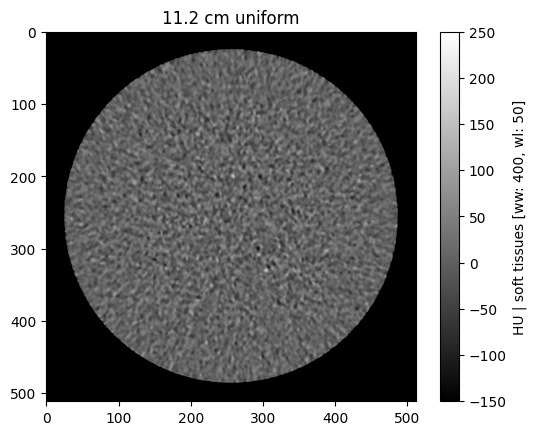

In [13]:
browse_studies(results, phantom='uniform', fov=12, dose=25, recon='RED-CNN')

In [14]:
study_viewer(results)

interactive(children=(Dropdown(description='phantom', options=('uniform',), value='uniform'), Dropdown(descrip…

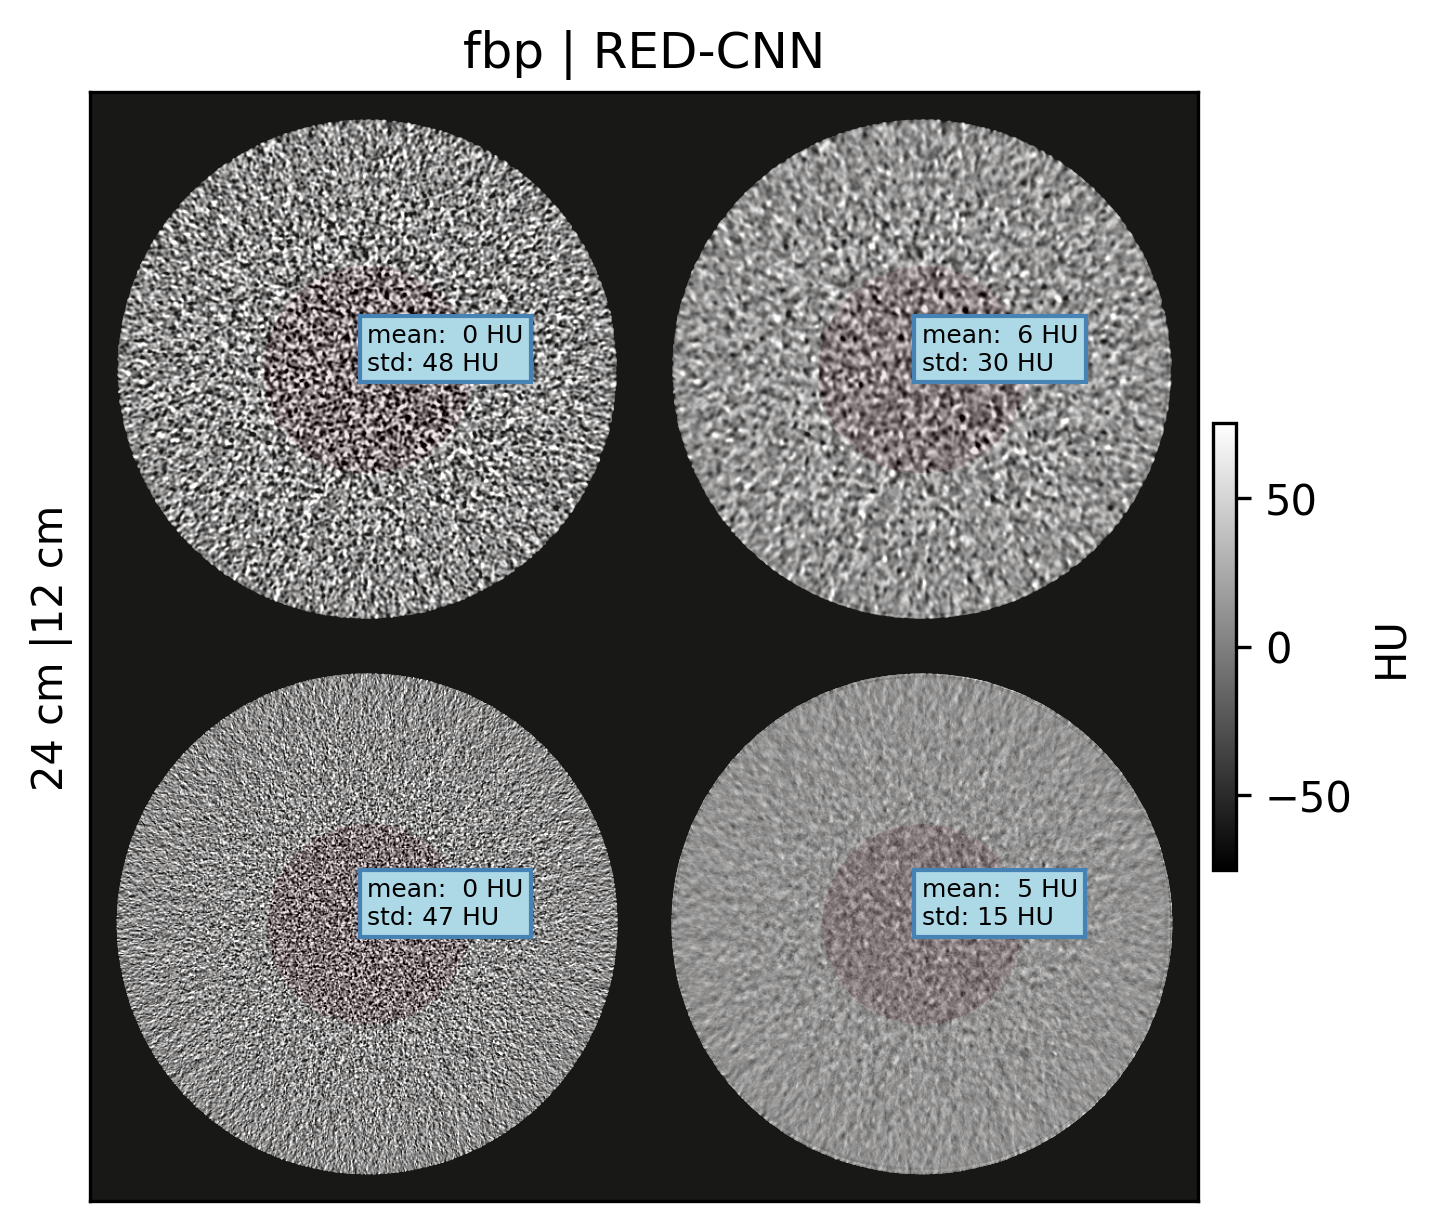

In [15]:
from utils import make_montage
plt.figure(dpi=300)
make_montage(results, roi_diameter=0.4, fovs=[12, 24], wwwl=(150, 0))

In [16]:
from utils import measure_roi_std
%timeit measure_roi_std(results.file.iloc[1])

34.5 ms ± 3.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
len(results)

3200

In [18]:
31/1000*3200/60

1.6533333333333333

This takes about 1-2 min to make all of the noise measurements across 3200 images

In [19]:
results['noise std [HU]'] = results.file.apply(measure_roi_std)
results

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],file,patientid,studyid,series,repeat,noise std [HU]
0,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,0,47.516051
1,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,RED-CNN,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,0,29.654159
2,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,1,47.171546
3,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,RED-CNN,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,1,28.723239
4,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,2,48.069435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,35.0 cm uniform,35.0,39.0,adult,uniform,Siemens Somatom Definition,25.0,RED-CNN,D45,39.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,23.0,92,simulation,197,9.838238
3196,35.0 cm uniform,35.0,39.0,adult,uniform,Siemens Somatom Definition,25.0,fbp,D45,39.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,23.0,92,simulation,198,45.688956
3197,35.0 cm uniform,35.0,39.0,adult,uniform,Siemens Somatom Definition,25.0,RED-CNN,D45,39.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,23.0,92,simulation,198,9.570099
3198,35.0 cm uniform,35.0,39.0,adult,uniform,Siemens Somatom Definition,25.0,fbp,D45,39.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,23.0,92,simulation,199,45.712969


<Axes: xlabel='FOV [cm]', ylabel='noise std [HU]'>

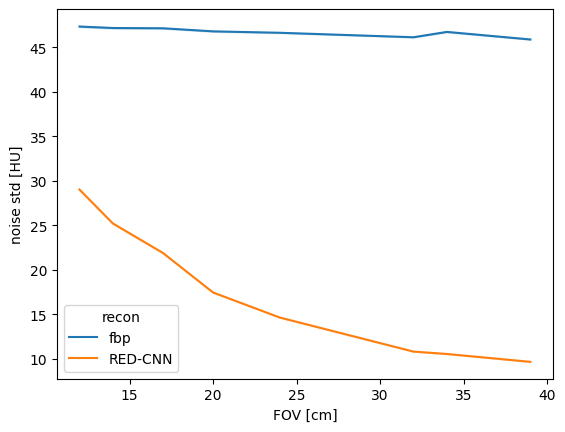

In [20]:
import seaborn as sns
sns.lineplot(data=results, x='FOV [cm]', y='noise std [HU]', hue='recon')

In [21]:
from utils import calculate_noise_reduction

In [22]:
results = calculate_noise_reduction(results)
results.head()

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],file,patientid,studyid,series,repeat,noise std [HU],noise std [HU] reduction [%]
0,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,0,47.516051,-0.389835
1,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,RED-CNN,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,0,29.654159,37.347990
2,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,1,47.171546,0.338020
3,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,RED-CNN,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,1,28.723239,39.314797
4,11.2 cm uniform,11.2,0.083333,newborn,uniform,Siemens Somatom Definition,25.0,fbp,D45,12.0,/gpfs_projects/brandon.nelson/RSTs/pediatricIQ...,16.0,64,simulation,2,48.069435,-1.559000


<Axes: xlabel='FOV [cm]', ylabel='noise std [HU] reduction [%]'>

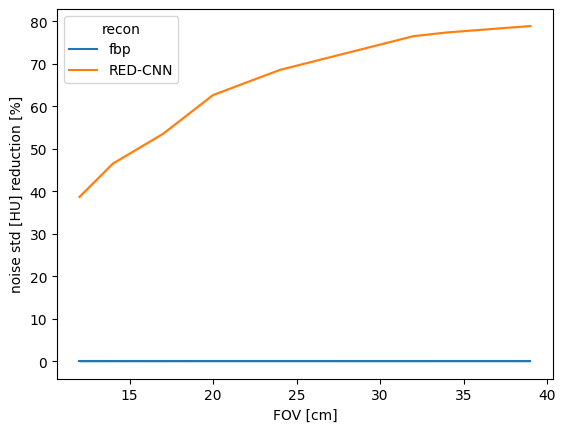

In [23]:
sns.lineplot(data=results, x='FOV [cm]', y='noise std [HU] reduction [%]', hue='recon')

Text(0, 0.5, 'Mean Effective Diameter [cm]')

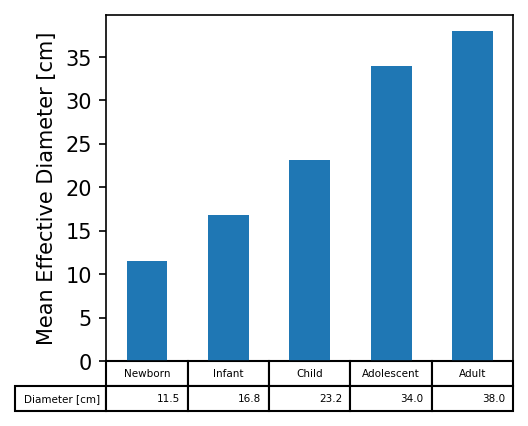

In [24]:
df = pd.DataFrame({'Subgroup': ['Newborn', 'Infant', 'Child', 'Adolescent', 'Adult'],
                   'Diameter [cm]':[11.5, 16.8, 23.2, 34, 38],
                   'Age [yrs]': [0, 2, 12, 21, 38]})
f, ax=plt.subplots(figsize=(3.5,3), dpi=150)
df.plot.bar(ax=ax, x='Subgroup',y='Diameter [cm]', table=True, legend=False)
ax.get_xaxis().set_visible(False)
ax.set_ylabel('Mean Effective Diameter [cm]')

<Axes: xlabel='pediatric subgroup', ylabel='noise std [HU] reduction [%]'>

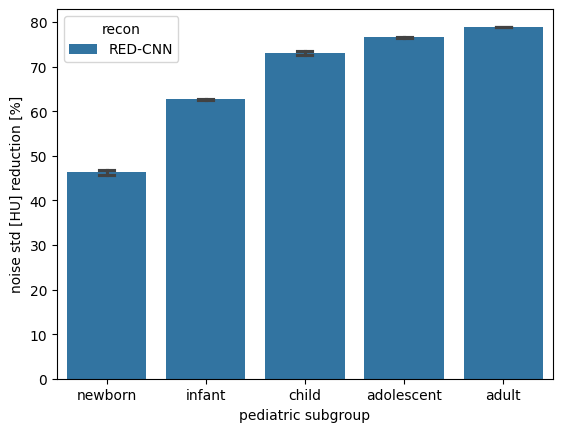

In [25]:
sns.barplot(data=results[results.recon != 'fbp'], x='pediatric subgroup', y='noise std [HU] reduction [%]', hue='recon', capsize=0.15)